In [12]:
import torch
#from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM, BertConfig, BertForSequenceClassification
from pytorch_pretrained_bert import *
import torch.optim as optim
from tensorflow import keras
import numpy as np
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

In [13]:
import logging
logging.basicConfig(level=logging.INFO)

# bert_model = BertModel.from_pretrained('bert-base-uncased') 
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# modelConfig = BertConfig.from_pretrained('bert_config')

data_path='./dataset/' # Folders for training and test sets 训练集、测试集存放目录 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, do_basic_tokenize=True)# Get the word list 获取词表
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels = 3)# Load the BERT pre-trained model 获取BERT预训练模型文件

INFO:pytorch_pretrained_bert.tokenization:loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at C:\Users\15049\.pytorch_pretrained_bert\26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
INFO:pytorch_pretrained_bert.modeling:loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at C:\Users\15049\.pytorch_pretrained_bert\9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
INFO:pytorch_pretrained_bert.modeling:extracting archive file C:\Users\15049\.pytorch_pretrained_bert\9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir C:\Users\15049\AppData\Local\Temp\tmptf9804r5
INFO:pytorch_pretrained_bert.modeling:Model config {
  "atte

In [14]:
# Read CSV file to load the labels of test set 读取CSV文件，用于获取测试集labels
def read_CSV(file_name):
    testset_features=[] #features' list
    testset_labels=[]   #labels' list
    try:
            with open(file_name,'r') as file_object:                
                    reader_CSV=csv.reader(file_object)
                    num_lines = 0
                    for oneline in reader_CSV:
                            testset_features.append(oneline[0])
                            testset_labels.append(oneline[1])
                            num_lines += 1
    except FileNotFoundError:
            print('Cannot find the .csv file ' + file_name+'.') 
    else:
            print('The test set index list is : \n\b'+str(testset_features)+'\n\n\n\nThe test set lable list is: \n\b'+str(testset_labels))
            print('\n\nSucceed to load the test set labels from '+file_name+'! The data set contains '+str(num_lines)+' samples in total.')    
            return testset_labels


In [15]:
# Sentence processing function  语句处理函数定义
def preprocessing (filename):

    df = pd.read_csv(os.path.join(data_path,filename), delimiter='\t', header=None,\
         names=['id', 'tweet', 'subtask_a', 'subtask_b', 'subtask_c'])  # names=['sentence_source', 'label', 'label_notes', 'sentence']

    # Extract sentences 提取语句
    sentencses=['[CLS] ' + sent + ' [SEP]' for sent in df.tweet.values][1:]  
    labels=df.subtask_c.values[1:]          # define point

    print("第一句话:",sentencses[0])
    tokenized_sents=[tokenizer.tokenize(sent) for sent in sentencses]
    print("tokenized的第一句话:",tokenized_sents[0])

    # Define the max length of sentences 定义句子最大长度
    MAX_LEN=128

    # Transfer the segmented sentences into numbers 将分割后的句子转化成数字  word-->idx
    input_ids=[tokenizer.convert_tokens_to_ids(sent) for sent in tokenized_sents]
    print("转化后的第一个句子:",input_ids[0])

    # Use keras for PADDING, runcating means truncation greater than the maximum length, truncation greater than 128, PADDING less than 128 用keras做PADDING，runcating表示大于最大长度截断，大于128做截断，小于128做PADDING
    input_ids = keras.preprocessing.sequence.pad_sequences(input_ids, maxlen=MAX_LEN, dtype="int64", truncating="post", padding="post")
    print("Padding 第一个句子:",input_ids[0])


    # Generate mask 生成mask
    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    print("第一个attention mask:",attention_masks[0])
    return input_ids,attention_masks,labels

In [16]:
# Read the file for training set and test set 读取训练集，测试集文件
[train_inputs,train_masks,train_labels] = preprocessing ("Qc_olid-training-v1.0.tsv")# define point
[test_inputs,test_masks,_] = preprocessing ("testset-levelc.tsv")   # define point
test_labels = read_CSV(file_name=".\dataset\labels-levelc.csv")     # define point


train_labels = [0 if i=='IND' else i for i in train_labels]         # define point
train_labels = [1 if i=='OTH' else i for i in train_labels]         # define point
train_labels = [2 if i=='GRP' else i for i in train_labels]         # define point

test_labels = [0 if i=='IND' else i for i in test_labels]           # define point
test_labels = [1 if i=='OTH' else i for i in test_labels]           # define point
test_labels = [2 if i=='GRP' else i for i in test_labels]           # define point

print(train_labels)
print(test_labels)                                                  

第一句话: [CLS] @USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL [SEP]
tokenized的第一句话: ['[CLS]', '@', 'user', '@', 'user', 'go', 'home', 'you', '’', 're', 'drunk', '!', '!', '!', '@', 'user', '#', 'mag', '##a', '#', 'trump', '##20', '##20', '[UNK]', 'ur', '##l', '[SEP]']
转化后的第一个句子: [101, 1030, 5310, 1030, 5310, 2175, 2188, 2017, 1521, 2128, 7144, 999, 999, 999, 1030, 5310, 1001, 23848, 2050, 1001, 8398, 11387, 11387, 100, 24471, 2140, 102]
Padding 第一个句子: [  101  1030  5310  1030  5310  2175  2188  2017  1521  2128  7144   999
   999   999  1030  5310  1001 23848  2050  1001  8398 11387 11387   100
 24471  2140   102     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0   

In [17]:
# Transform the training and validation sets into tensors, and acquire inputs, masks, and labels 将训练集、验证集转化成tensor，获取inputs，masks和labels
train_inputs = torch.tensor(train_inputs)
test_inputs = torch.tensor(test_inputs)
train_masks = torch.tensor(train_masks)
test_masks = torch.tensor(test_masks)
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)


# Create dataloader 创建dataloader
batch_size = 16
train_data = torch.utils.data.TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = torch.utils.data.RandomSampler(train_data)
train_dataloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
test_data = torch.utils.data.TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = torch.utils.data.SequentialSampler(test_data)
test_dataloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [18]:
print(model.cuda())
next(model.parameters()).is_cuda

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

True

In [19]:
# Optimizer definition, try Adam and SDG with momentum 优化器定义，尝试Adam和带momentum的的SDG
param_optimizer = list(model.named_parameters())

# optimizer = BertAdam(optimizer_grouped_parameters, lr=10**-4, warmup=-1, t_total=-1)
optimizer = optim.SGD(model.parameters(), lr = 0.00012, weight_decay= 10**-7, momentum = 0.8)


In [20]:
# The function for visualisation of loss and accuracy  loss和accuracy的可视化函数定义
def convergence_result_visualisation (average_loss_epoch, accuracy_testset, list_epochs):
  plt.figure(figsize=(8,4))
  plt.subplot(1,2,1)
  plt.title("Accuracy on test set with Epochs")
  plt.xlabel("Training Epochs")
  plt.ylabel("Accuracy on test set")
  plt.plot(list_epochs, accuracy_testset ,label="Accuracy")
  plt.ylim((0,1.))
  plt.xlim(left=0)
  plt.legend(frameon=True)

  plt.subplot(1,2,2)
  plt.title("Loss function value on training set with Epochs")
  plt.xlabel("Training Epochs")
  plt.ylabel("Loss function value on training set")
  plt.plot(list_epochs,average_loss_epoch, label="Loss",color='red')
  plt.xlim(left=0)
  plt.legend(frameon=True)
  plt.tight_layout()
  plt.show()

In [21]:
# Get the class corresponding to maximum probability with argmax and then calculate the accuracy  用argmax获取最大概率对应类，计算准确率
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Begin training 开始训练
train_loss_set = []
epochs = 10
plot_accuracy=[]
plot_loss=[]
for num_epochs in trange(epochs, desc="Epoch"):

    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to('cuda') for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        #取第一个位置，BertForSequenceClassification第一个位置是Loss，第二个位置是[CLS]的logits
        # https://huggingface.co/transformers/model_doc/bert.html 
        # https://github.com/yuzcccc/pytorch-pretrained-BERT/blob/master/examples/run_classifier.py
        loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        train_loss_set.append(loss.item())
        loss.backward()
        optimizer.step()

        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
    
    # Performance evaluation 模型performance评估
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    for batch in test_dataloader:
        batch = tuple(t.to('cuda') for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
        
    print("\nLoss function on training set: {}".format(tr_loss / nb_tr_steps))
    print("Accuracy on test set: {}".format(eval_accuracy / nb_eval_steps))
    print('\n')
    plot_loss.append(tr_loss / nb_tr_steps)    
    plot_accuracy.append(eval_accuracy / nb_eval_steps)


Epoch:  10%|███████▌                                                                    | 1/10 [01:23<12:27, 83.05s/it]


Loss function on training set: 0.8857119367937002
Accuracy on test set: 0.4660714285714286




Epoch:  20%|███████████████▏                                                            | 2/10 [02:47<11:06, 83.35s/it]


Loss function on training set: 0.8300133997520792
Accuracy on test set: 0.6178571428571429




Epoch:  30%|██████████████████████▊                                                     | 3/10 [04:10<09:44, 83.51s/it]


Loss function on training set: 0.7702545607040939
Accuracy on test set: 0.6767857142857142




Epoch:  40%|██████████████████████████████▍                                             | 4/10 [05:35<08:22, 83.72s/it]


Loss function on training set: 0.7156551453311748
Accuracy on test set: 0.6901785714285714




Epoch:  50%|██████████████████████████████████████                                      | 5/10 [06:59<06:59, 83.88s/it]


Loss function on training set: 0.6877037368929435
Accuracy on test set: 0.7125




Epoch:  60%|█████████████████████████████████████████████▌                              | 6/10 [08:23<05:36, 84.02s/it]


Loss function on training set: 0.6741135016145039
Accuracy on test set: 0.7035714285714285




Epoch:  70%|█████████████████████████████████████████████████████▏                      | 7/10 [09:48<04:12, 84.32s/it]


Loss function on training set: 0.663501595457395
Accuracy on test set: 0.7080357142857142




Epoch:  80%|████████████████████████████████████████████████████████████▊               | 8/10 [11:11<02:47, 83.87s/it]


Loss function on training set: 0.6551864768987821
Accuracy on test set: 0.7080357142857142




Epoch:  90%|████████████████████████████████████████████████████████████████████▍       | 9/10 [12:34<01:23, 83.69s/it]


Loss function on training set: 0.6499652023055426
Accuracy on test set: 0.6946428571428571




Epoch: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [13:57<00:00, 83.71s/it]


Loss function on training set: 0.6401664996711315
Accuracy on test set: 0.7214285714285714




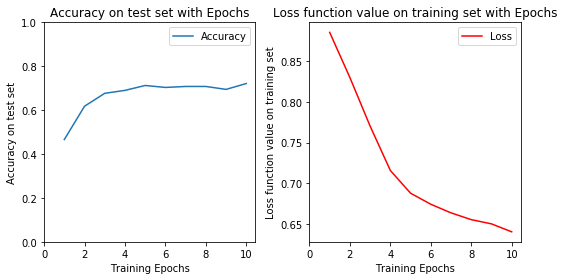

In [22]:
x_axis = list(range(1,num_epochs+2))
convergence_result_visualisation (plot_loss, plot_accuracy, x_axis) # Visualise network's performance 绘图